# Predicting Housing Prices with the Ames Dataset

<h3>Task at Hand:</h3><br>
<strong>Using the Ames housing dataset, predict 'SalePrice' based on a number of characteristics about the house. Predict with an accuracy of .15 (RMSE).</strong>

## Step 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.max_columns = None

## Step 2. Get the data

In [2]:
train_original = pd.read_csv("../data/raw/train.csv")
test_original = pd.read_csv("../data/raw/test.csv")

In [3]:
train_original.shape

(1460, 81)

In [4]:
test_original.shape

(1459, 80)

## Step 3. Feature Engineering

### Step 3a. Inspect (and transform) the target variable, 'SalePrice'.

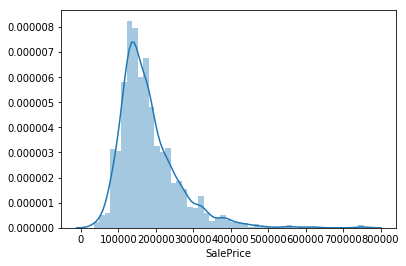

In [5]:
sns.distplot(train_original['SalePrice']);

This is right skewed.  We can apply the 'log1p' tranformation to help better distribute the data.

In [6]:
# Before we start modifying data, make a copy to leave "originals" intact.
train = train_original.copy()
test = test_original.copy()

In [7]:
# Apply the transformation to our working DataFrame.
train['SalePrice'] = np.log1p(train['SalePrice'])

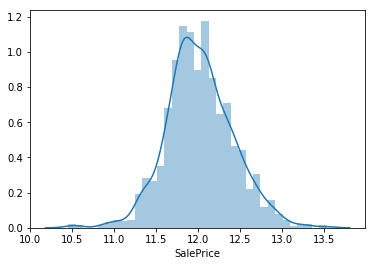

In [8]:
sns.distplot(train['SalePrice']);

This looks better.

### Step 3b. Feature Selection: First Pass

This dataset has eighty features, which is a bit overwhelming. First, I will go through each feature to determine the following:<br><br>
1) <strong>Intuition:</strong> Does this feature seem relavant on an intuitive level?<br>
2) <strong>Correlation:</strong> Does the feature seem to have any correlation with our target value, SalePrice?<br>
3) <strong>Redundancy:</strong> Does the feature indicate roughly the same thing as another feature?<br>
4) <strong>Distribution:</strong> Does the feature have a relatively normal distribution if continuous? If categorical, how does the data break down?  For example, are there only a few rows that have a certain Porch property?<br>
5) <strong>Outliers:</strong> Does the data have a lot of outliers?<br>
6) <strong>Nulls:</strong> Are there a lot of null values? How will we deal with them?<br>
7) <strong>Encoding:</strong> If categorical, can we easily encode the values without adding too many columns?<br><br>
Here, I determine whether or not to include a few features based on the above thought process.<br><br>
<i>Note: I use Google Sheets to keep track of the characteristics of the features.</i>

#### Some useful analysis functions before getting started:

In [9]:
def cat_inspect(df, independent):
    """Provides distribution data for an independent variable 
    and an independent/SalePrice correlation visualization
    (for categorical variables).
    """
    print("Value Counts\n{0}".format(df[independent].value_counts()))
    ax = sns.boxplot(df[independent], df['SalePrice'])
    ax.set_title(independent)
    
def cont_inspect(df, independent):
    """Provides distribution data for an independent variable 
    and an independent/SalePrice correlation visualization
    (for categorical variables).
    """
    print("Number of NaNs: {0}".format(df[independent].isnull().sum()))
    ax1 = sns.scatterplot(x=df[independent], y=df['SalePrice'])
    ax1.set_title("{0} vs. SalePrice".format(independent))
    ax1 = plt.figure();
    ax2 = sns.distplot(df[independent])
    ax2.set_title("{0} Distribution".format(independent))
    ax2 = plt.figure();

#### Example 1: OverallQual (Categorical)

Value Counts
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64


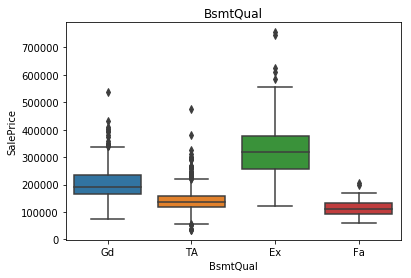

In [58]:
cat_inspect(train_original, 'OverallQual')

#### Example 2: GrLivArea (Continuous)

Number of NaNs: 0


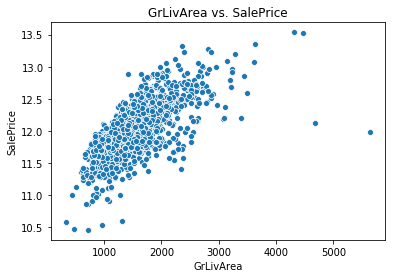

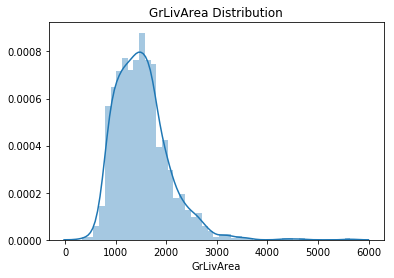

<Figure size 432x288 with 0 Axes>

In [11]:
cont_inspect(train, 'GrLivArea')

#### Drop Columns: First Pass

In [12]:
to_drop = ['Heating','BldgType','Alley','Street',
           'Utilities','MSSubClass','LotFrontage','LotShape',
           'LandContour','Neighborhood','Condition1','Condition2',
           'OverallCond','YearBuilt','YearRemodAdd','RoofMatl',
           'Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
           'ExterQual','Foundation','BsmtQual','BsmtFinSF1','BsmtCond','BsmtExposure',
           'BsmtFinType2','BsmtFinSF2','BsmtUnfSF','HeatingQC','Electrical',
           'LowQualFinSF','BsmtFullBath',
           'BsmtHalfBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
           'Functional','Fireplaces','FireplaceQu','GarageType',
           'GarageYrBlt','GarageFinish','GarageArea','GarageQual',
           'GarageCond','WoodDeckSF','OpenPorchSF','EnclosedPorch',
           '3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence',
           'MiscFeature','MiscVal','MoSold','YrSold','SaleType',
           'SaleCondition', 'LotArea', 'TotRmsAbvGrd', 'MSZoning',
           'LotConfig','LandSlope','ExterCond']

train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

That brings us down to a much more reasonable size.  Next, we will do a more in-depth look at each of the features to get a better understanding of the transformations that need to take place before sending it to our algorithm.

### Step 3c. Fixing Nulls

Let's see if we have any columns with null values.  We will want to fill any null values prior to applying any transformations to our features

In [13]:
features = ['HouseStyle','OverallQual','TotalBsmtSF',
            'GrLivArea','FullBath','KitchenQual','GarageCars','RoofStyle','BsmtFinType1',
           'PavedDrive','CentralAir','1stFlrSF','2ndFlrSF']

In [14]:
for feature in features:
    if train[feature].isnull().sum().sum()>0:
        print("Train / {0}: {1} nulls".format(feature, train[feature].isnull().sum().sum()))
    if test[feature].isnull().sum().sum()>0:
        print("Test / {0}: {1} nulls".format(feature, test[feature].isnull().sum().sum()))

Test / TotalBsmtSF: 1 nulls
Test / KitchenQual: 1 nulls
Test / GarageCars: 1 nulls
Train / BsmtFinType1: 37 nulls
Test / BsmtFinType1: 42 nulls


##### Test / TotalBsmtSF

In [15]:
test_original[test_original['TotalBsmtSF'].isnull()] # I am using test_original here to get more context.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


Let's change the value to '0' because it looks like they don't have a basement

In [16]:
test.TotalBsmtSF.fillna(0, inplace=True)

In [17]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

sf_drop = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']

train = train.drop(sf_drop, axis=1)
test = test.drop(sf_drop, axis=1)

##### Test / KitchenQual

In [18]:
test_original[test_original['KitchenQual'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,72.0,10632,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,NaN,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,NaN,NaN,NaN,0,1,2010,COD,Normal


I'm going to assume that because their basement quality is "Good", that perhaps their kitchen is as well.

In [19]:
test.KitchenQual.fillna('Gd', inplace=True)

##### Test / GarageCars

In [20]:
test_original[test_original['GarageCars'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,2577,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


In [21]:
test_original['GarageCars'].value_counts()

2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: GarageCars, dtype: int64

Let's go with the mode of 2.0.

In [22]:
test.GarageCars.fillna(2.0, inplace=True)

##### Train / BsmtFinType1

In [23]:
train.BsmtFinType1.fillna('NoBase', inplace=True)

##### Test / BsmtFinType1

In [24]:
test.BsmtFinType1.fillna('NoBase', inplace=True)

### Step 3d. Fix outliers in train set & apply log transformations to continuous variables

##### TotalBsmtSF

Number of NaNs: 0


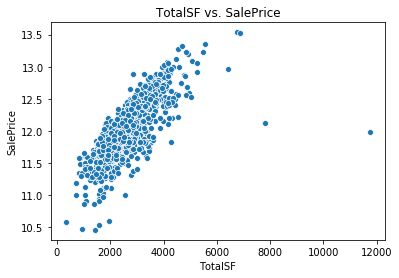

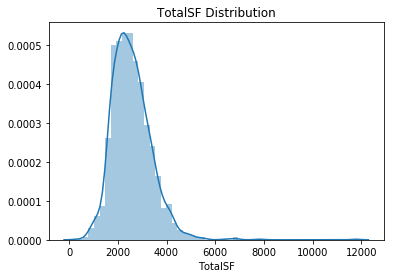

<Figure size 432x288 with 0 Axes>

In [25]:
cont_inspect(train, 'TotalSF')

In [26]:
train = train.drop(train[(train['TotalSF']>7000)].index)

In [27]:
train['TotalSF'] = np.log1p(train['TotalSF'])
test['TotalSF'] = np.log1p(test['TotalSF'])

Number of NaNs: 0


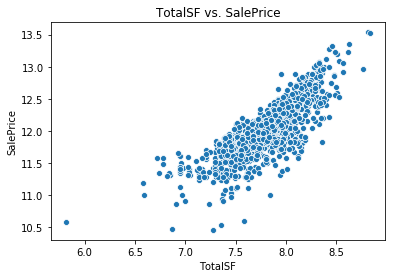

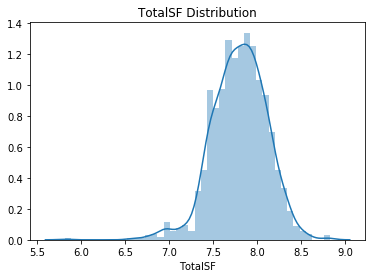

<Figure size 432x288 with 0 Axes>

In [28]:
cont_inspect(train, 'TotalSF')

##### GrLivArea

In [29]:
#cont_inspect(train, 'GrLivArea')

In [30]:
#train = train.drop(train[(train['GrLivArea']>4600)].index)

In [31]:
#train['GrLivArea'] = np.log1p(train['GrLivArea'])
#test['GrLivArea'] = np.log1p(test['GrLivArea'])

In [32]:
#cont_inspect(train, 'GrLivArea')

### Step 3e. (Optional) Visualize your numerical features

Let's see how our numerical features correlate with a heat map.

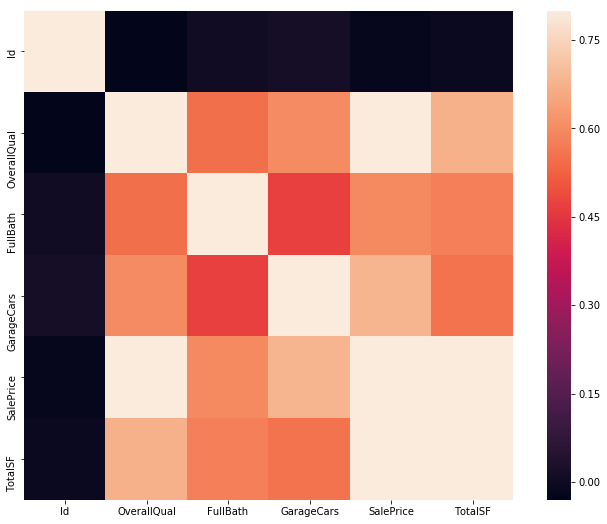

In [33]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Looks good.

### Step 3f. Feature Encoding

#### Concatenate the train and test DataFrames

We do this to ensure that our columns are the same between our train and test DataFrames after we transform the columns.

In [34]:
print("Train shape: {0}".format(train.shape))
print("Test shape: {0}".format(test.shape))

Train shape: (1458, 12)
Test shape: (1459, 11)


Let's add a "dummy" column to test and concatenate the two datasets.

In [35]:
test['SalePrice'] = -1

In [36]:
print("Train shape: {0}".format(train.shape))
print("Test shape: {0}".format(test.shape))

Train shape: (1458, 12)
Test shape: (1459, 12)


In [37]:
data = pd.concat([train, test])

In [38]:
data.sample(10) # Notice the dummy 'SalePrice' values.

,BsmtFinType1,CentralAir,FullBath,GarageCars,HouseStyle,Id,KitchenQual,OverallQual,PavedDrive,RoofStyle,SalePrice,TotalSF
856,GLQ,Y,1,2.0,SLvl,857,TA,6,Y,Gable,11.898195,7.584265
1233,Rec,Y,1,2.0,1Story,1234,TA,5,Y,Hip,11.863589,7.773594
1127,GLQ,Y,2,3.0,1Story,1128,Gd,7,Y,Hip,12.464587,8.026497
1104,NoBase,Y,1,2.0,1Story,2565,TA,5,Y,Gable,-1.000000,7.112327
1108,Unf,Y,2,2.0,2Story,1109,TA,6,Y,Gable,12.106258,7.869019
504,ALQ,Y,2,2.0,2Story,1965,TA,6,Y,Gable,-1.000000,7.745868
65,Unf,Y,2,3.0,2Story,66,Gd,8,Y,Gable,12.666660,8.193400
581,Unf,Y,2,3.0,1Story,582,Ex,8,Y,Hip,12.442306,8.315077
1109,GLQ,Y,1,2.0,2Story,2570,TA,6,Y,Gable,-1.000000,7.353722
29,Unf,N,1,1.0,1Story,30,Fa,4,Y,Gable,11.134604,6.947937


#### Transformations

##### TotalBsmtSF

Let's split this into fewer values by using pd.qcut.  It break out continuous variable into smaller categories

In [39]:
#data['TotalBsmtSF'] = pd.qcut(data['TotalBsmtSF'], 10, labels=False)

##### GrLivArea

In [40]:
#data['GrLivArea'] = pd.qcut(data['GrLivArea'], 10, labels=False)

##### BsmtFinType1, CentralAir, HouseStyle, KitchenQual, RoofStyle, PavedDrive

In [41]:
get_dummies_cats = ['BsmtFinType1', 'CentralAir', 'HouseStyle', 'KitchenQual', 'RoofStyle', 'PavedDrive']

data = pd.get_dummies(data, columns=get_dummies_cats)

We'll use get_dummies on this column.

In [42]:
data.head()

,FullBath,GarageCars,Id,OverallQual,SalePrice,TotalSF,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBase,BsmtFinType1_Rec,BsmtFinType1_Unf,CentralAir_N,CentralAir_Y,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,2,2.0,1,7,12.247699,7.850493,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,2,2.0,2,6,12.109016,7.833996,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,2,2.0,3,7,12.317171,7.903596,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
3,1,3.0,4,7,11.849405,7.813592,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,2,3.0,5,8,12.429220,8.114923,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


### Re-split data

In [43]:
data_train = data.iloc[:1458]
data_test = data.iloc[1458:]

sale_prices = data_train["SalePrice"]
data_train.drop(['SalePrice'], axis=1, inplace=True)

data_test.drop(['SalePrice'], axis=1, inplace=True)

## Step 4: Modeling

### Imports

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

/Users/thomasdolan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Linear Regression

In [45]:
lr = LinearRegression()
lr.fit(data_train, sale_prices)
train_predictions = lr.predict(data_train)
train_rmse = np.sqrt(mean_squared_error(train_predictions, sale_prices))
print("RMSE of Linear Regression:", train_rmse)

RMSE of Linear Regression: 0.14536099363398583


### Lasso

In [46]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso = Lasso(alpha =0.0001, random_state=1)
lasso.fit(data_train, sale_prices)
train_predictions = lasso.predict(data_train)
train_rmse = np.sqrt(mean_squared_error(train_predictions, sale_prices))
print("RMSE of Lasso:", train_rmse)

RMSE of Lasso: 0.14542578641323242


### Elastic

In [47]:
elastic = ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=1)
elastic.fit(data_train, sale_prices)
train_predictions = elastic.predict(data_train)
train_rmse = np.sqrt(mean_squared_error(train_predictions, sale_prices))
print("RMSE of Elastic Net:", train_rmse)

RMSE of Elastic Net: 0.1463523454068177


### Gradient Boost

In [48]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
gboost.fit(data_train, sale_prices)
train_predictions = gboost.predict(data_train)
train_rmse = np.sqrt(mean_squared_error(train_predictions, sale_prices))
print("RMSE of Gradient Boost:", train_rmse)

RMSE of Gradient Boost: 0.08699954492104542


In [49]:
#final_predictions = lr.predict(data_test)

In [50]:
#final_predictions = lasso.predict(data_test)

In [51]:
#final_predictions = elastic.predict(data_test)

In [52]:
final_predictions = gboost.predict(data_test)

In [53]:
final_predictions = np.expm1(final_predictions)

In [54]:
final_predictions

array([112777.09593698, 151384.0590479 , 179850.64124023, ...,
       146955.47304163, 109647.32229385, 221762.29849868])

In [55]:
data_test['SalePrice'] = final_predictions

In [56]:
data_test.head()

,FullBath,GarageCars,Id,OverallQual,TotalSF,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBase,BsmtFinType1_Rec,BsmtFinType1_Unf,CentralAir_N,CentralAir_Y,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePrice
0,1,1.0,1461,5,7.483807,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,112777.095937
1,1,1.0,1462,6,7.885705,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,151384.059048
2,2,2.0,1463,5,7.846981,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,179850.641240
3,2,2.0,1464,6,7.836370,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,199350.002110
4,2,2.0,1465,8,7.848153,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,187124.787548


In [57]:
data_test[['Id', 'SalePrice']].to_csv('gb_predictions.csv', index=False)

Thanks to Serigne Stacked Regressions : Top 4% on LeaderBoard for reference!